# First tests of inference methods on the epidemiology problem

In [44]:
import numpy as np
import corner
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

## One theta

In [45]:
sample_sizes = [100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000]
methods = ['histogram', 'maf', 'scandal']
method_labels = ['Histogram', 'MAF', 'SCANDAL']

In [46]:
expected_log_likelihoods = []
log_likelihood_mses = []
roc_aucs = []

log_likelihood_reference = np.load(
    '../data/results/epidemiology/scandal/log_p_hat_test_singletheta_trainedonsingletheta.npy'
)

for method in methods:
    log_likelihood_mses_this_method = []
    roc_aucs_this_method = []
    expected_log_likelihoods_this_method = []
    
    for sample_size in sample_sizes:
        log_likelihood = np.load('../data/results/epidemiology/' + method
                                 + '/log_p_hat_test_trainingsamplesize_'
                                 + str(sample_size) + '.npy')
        try:
            roc_auc = np.load('../data/results/epidemiology/' + method
                              + '/roc_auc_surrogate_vs_simulator_trainingsamplesize_' + str(sample_size)
                              + '.npy')
        except FileNotFoundError:
            roc_auc = np.nan
        
        try:
            mse = mean_squared_error(log_likelihood_reference, log_likelihood)
        except ValueError:
            mse = np.nan
        expected_log_likelihood = 1. / log_likelihood.shape[0] * np.sum(log_likelihood)
        
        expected_log_likelihoods_this_method.append(expected_log_likelihood)
        roc_aucs_this_method.append(roc_auc)
        log_likelihood_mses_this_method.append(mse)
        
    log_likelihood_mses.append(log_likelihood_mses_this_method)
    roc_aucs.append(roc_aucs_this_method)
    expected_log_likelihoods.append(expected_log_likelihoods_this_method)
    
expected_log_likelihoods = np.array(expected_log_likelihoods)
log_likelihood_mses = np.array(log_likelihood_mses)
roc_aucs = np.array(roc_aucs)


FileNotFoundError: [Errno 2] No such file or directory: '../data/results/epidemiology/scandal/log_p_hat_test_singletheta_trainedonsingletheta.npy'

IndexError: list index out of range

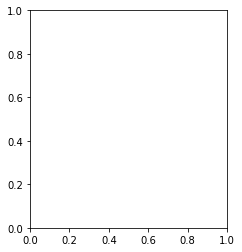

In [47]:
fig = plt.figure(figsize=(12,4))



ax = plt.subplot(1,3,1)

for m, method in enumerate(method_labels):
    plt.plot(sample_sizes, - expected_log_likelihoods[m],
             lw=1.5, ls='-', marker='o', ms=5.,
             label=method)
    
    plt.legend()
    
    plt.xlabel('Training sample size')
    plt.ylabel('Negative log likelihood')
    plt.ylim(-5.,100.)
    ax.set_xscale("log", nonposx='clip')



ax = plt.subplot(1,3,2)

for m, method in enumerate(method_labels):
    plt.plot(sample_sizes, log_likelihood_mses[m],
             lw=1.5, ls='-', marker='o', ms=5.,
             label=method)
    
    plt.legend()
    
    plt.xlabel('Training sample size')
    plt.ylabel('MSE (log likelihood) wrt high-statistics model')
    plt.ylim(0.,12000)
    ax.set_xscale("log", nonposx='clip')



ax = plt.subplot(1,3,3)

for m, method in enumerate(method_labels):
    plt.plot(sample_sizes, roc_aucs[m],
             lw=1.5, ls='-', marker='o', ms=5.,
             label=method)
    
    plt.legend()
    
    plt.xlabel('Training sample size')
    plt.ylabel('ROC AUC between simulator and surrogate samples')
    #plt.ylim(0.5,1.1)
    ax.set_xscale("log", nonposx='clip')
    
    

plt.tight_layout()
plt.show()


## Many thetas

In [48]:
sample_sizes = [100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000]
methods = ['histogram', 'maf', 'scandal']
method_labels = ['Histogram', 'MAF', 'SCANDAL']

In [49]:
expected_log_likelihoods = []
log_likelihood_mses = []
roc_aucs = []

log_likelihood_reference = np.load(
    '../data/results/epidemiology/scandal/log_p_hat_test.npy'
)

for method in methods:
    log_likelihood_mses_this_method = []
    roc_aucs_this_method = []
    expected_log_likelihoods_this_method = []
    
    for sample_size in sample_sizes:
        log_likelihood = np.load('../data/results/epidemiology/' + method
                                 + '/log_p_hat_test_trainingsamplesize_'
                                 + str(sample_size) + '.npy')
        try:
            roc_auc = np.load('../data/results/epidemiology/' + method
                              + '/roc_auc_surrogate_vs_simulator_trainingsamplesize_' + str(sample_size)
                              + '.npy')
        except FileNotFoundError:
            roc_auc = np.nan
        
        try:
            mse = mean_squared_error(log_likelihood_reference, log_likelihood)
        except ValueError:
            mse = np.nan
        expected_log_likelihood = 1. / log_likelihood.shape[0] * np.sum(log_likelihood)
        
        expected_log_likelihoods_this_method.append(expected_log_likelihood)
        roc_aucs_this_method.append(roc_auc)
        log_likelihood_mses_this_method.append(mse)
        
    log_likelihood_mses.append(log_likelihood_mses_this_method)
    roc_aucs.append(roc_aucs_this_method)
    expected_log_likelihoods.append(expected_log_likelihoods_this_method)
    
expected_log_likelihoods = np.array(expected_log_likelihoods)
log_likelihood_mses = np.array(log_likelihood_mses)
roc_aucs = np.array(roc_aucs)


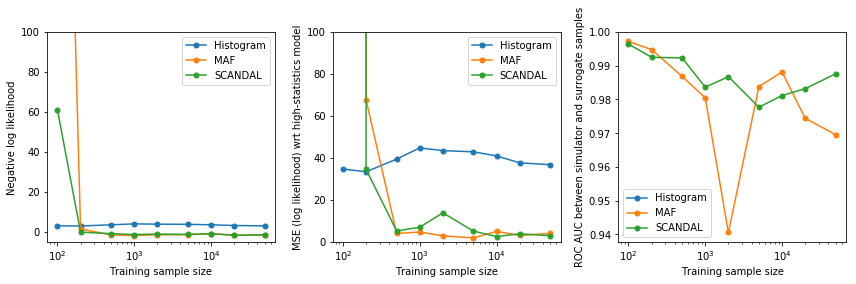

In [51]:
fig = plt.figure(figsize=(12,4))



ax = plt.subplot(1,3,1)

for m, method in enumerate(method_labels):
    plt.plot(sample_sizes, - expected_log_likelihoods[m],
             lw=1.5, ls='-', marker='o', ms=5.,
             label=method)
    
    plt.legend()
    
    plt.xlabel('Training sample size')
    plt.ylabel('Negative log likelihood')
    plt.ylim(-5.,100.)
    ax.set_xscale("log", nonposx='clip')



ax = plt.subplot(1,3,2)

for m, method in enumerate(method_labels):
    plt.plot(sample_sizes, log_likelihood_mses[m],
             lw=1.5, ls='-', marker='o', ms=5.,
             label=method)
    
    plt.legend()
    
    plt.xlabel('Training sample size')
    plt.ylabel('MSE (log likelihood) wrt high-statistics model')
    plt.ylim(0.,100)
    ax.set_xscale("log", nonposx='clip')



ax = plt.subplot(1,3,3)

for m, method in enumerate(method_labels):
    plt.plot(sample_sizes, roc_aucs[m],
             lw=1.5, ls='-', marker='o', ms=5.,
             label=method)
    
    plt.legend()
    
    plt.xlabel('Training sample size')
    plt.ylabel('ROC AUC between simulator and surrogate samples')
    #plt.ylim(0.5,1.1)
    ax.set_xscale("log", nonposx='clip')
    
    

plt.tight_layout()
plt.show()


## Original vs simulated samples

In [18]:
x_labels=['Shannon diversity', '# strains', 'Carriage',
        'Coinfection', 'Prevalence most common strain', '# singletons']
x_ranges = [(0.8,3.0), (3.5,22.5), (0.5, 1.), (0.,0.4), (0.,0.6), (-0.5,12.5)]
x_bins = [20, 19, 10, 7, 12, 12]

In [19]:
x_simulator = np.load('../data/samples/epidemiology/x_test_singletheta.npy')
x_maf = np.load('../data/results/epidemiology/scandal/samples_from_p_hat.npy')

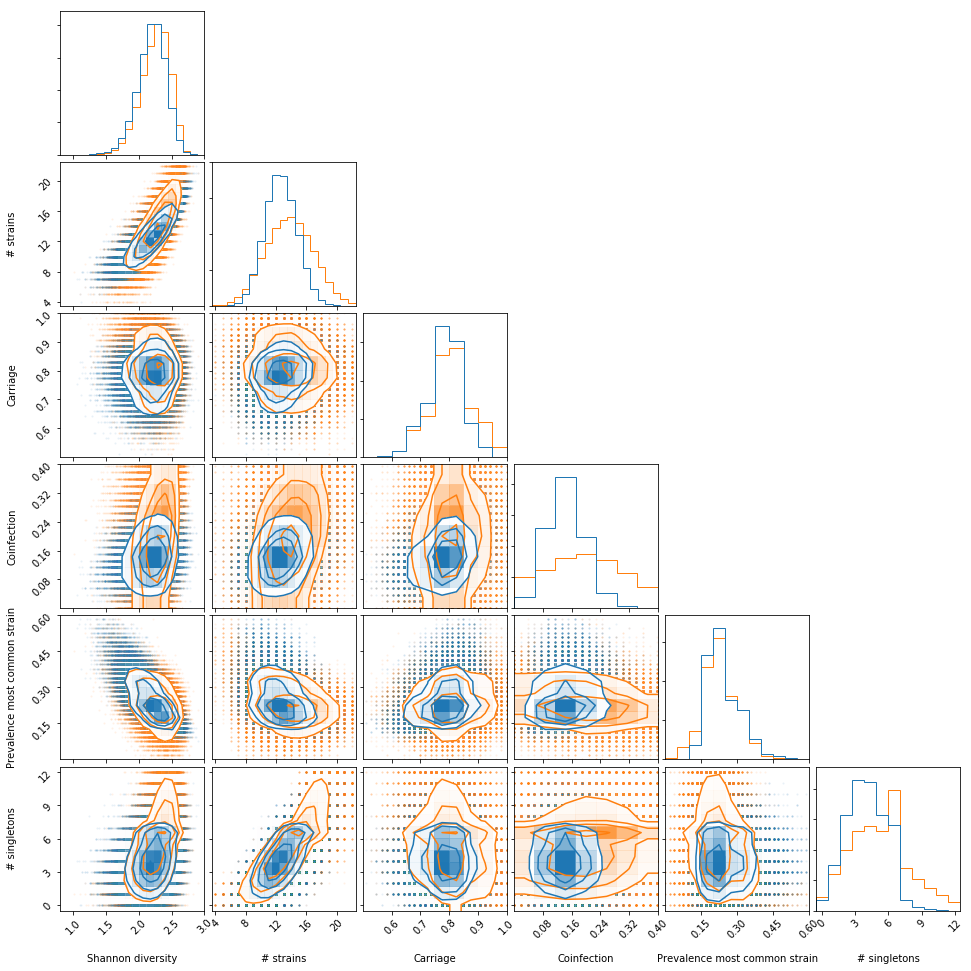

In [20]:
fig = corner.corner(x_maf,
                   labels=x_labels,
                   range=x_ranges,
                   bins=x_bins,
                   color='C1')
_ = corner.corner(x_simulator,
                   fig=fig,
                   labels=x_labels,
                   range=x_ranges,
                   bins=x_bins,
                   color='C0')